In [40]:
!pip install --upgrade certifi

You should consider upgrading via the '/Users/tarasbohdan/Desktop/projects/idea-contest-2023/ideation-api/venv/bin/python3.8 -m pip install --upgrade pip' command.


In [41]:
import os
import certifi

os.environ['SSL_CERT_FILE'] = certifi.where()

import numpy as np
import torch
import cv2
import supervision as sv

from mobile_sam import sam_model_registry, SamPredictor

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

In [42]:
current_directory = os.getcwd()

parent_directory = os.path.dirname(current_directory)

print("Current Directory:", current_directory)
print("Parent Directory:", parent_directory)

Current Directory: /Users/tarasbohdan/Desktop/projects/idea-contest-2023/ideation-api/notebooks
Parent Directory: /Users/tarasbohdan/Desktop/projects/idea-contest-2023/ideation-api


In [43]:
HOME = parent_directory
check_point_file = "mobile_sam.pt"
CHECKPOINT_PATH = os.path.join(HOME, "weights", f"{check_point_file}")
device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_TYPE = "vit_t"

mobile_sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=device)

predictor = SamPredictor(mobile_sam)

In [44]:
default_box= {'x': 50, 'y': 50, 'width': 330, 'height': 350, 'label': ''}

image_bgr = cv2.imread(f'{parent_directory}/data/dancing.jpg')

if image_bgr is None:
    print("Error: Image not found or unable to read.")
    exit()

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
box_annotator = sv.BoxAnnotator(color=sv.Color.red())

annotated_image = box_annotator.annotate(
    scene=image_bgr.copy(),
    detections=sv.Detections(xyxy=np.array([
        default_box['x'],
        default_box['y'],
        default_box['x'] + default_box['width'],
        default_box['y'] + default_box['height']
    ]).reshape(1, 4))
)

cv2.imwrite(os.path.join(parent_directory, "data", "annotated_image.jpeg"), annotated_image)

True

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [46]:
image_bgr = cv2.imread(f'{parent_directory}/data/dancing.jpg')

if image_bgr is None:
    print("Error: Image not found or unable to read.")
    exit()

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

height, width = image_bgr.shape[:2]
print(f"Image size: Width = {width}, Height = {height}")

predictor.set_image(image_rgb)
print('Predicting')

# scale_factor: float = width / 600 # FIXME receive this parameter from frontend
scale_factor: float = 1.0

# TODO load file with default box drawn to check if we get the correct box from the file
box_coords = np.array([
    default_box['x'] * scale_factor,
    default_box['y'] * scale_factor,
    (default_box['x'] + default_box['width']) * scale_factor,
    (default_box['y'] + default_box['height']) * scale_factor
])

masks, _, _ = predictor.predict(
    box=box_coords,
    multimask_output=False
)
print('Masks Generated')
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
cv2.imwrite(os.path.join(parent_directory, "data", "source_image.jpeg"), source_image)

segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
output_path = os.path.join(parent_directory, "data", "annotated_image_2.jpeg")
cv2.imwrite(output_path, segmented_image)

Image size: Width = 444, Height = 444
Predicting
Masks Generated


True

In [47]:
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()
])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader(f"{parent_directory}/data/picasso.jpg")
content_img = image_loader(f"{parent_directory}/data/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

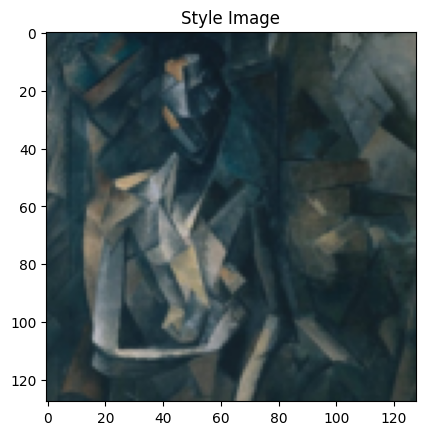

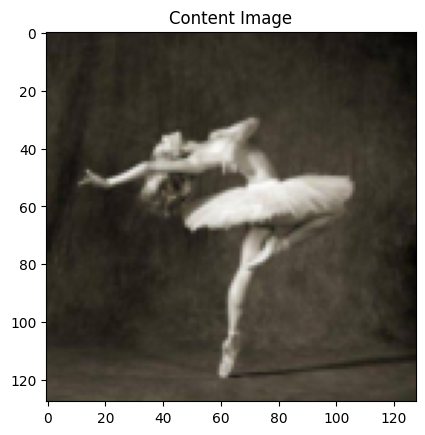

In [48]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [49]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

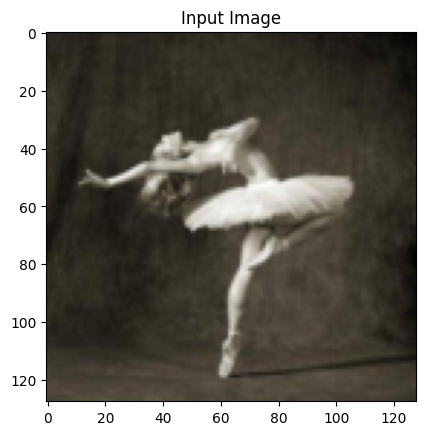

In [50]:
input_img = content_img.clone()
# if you want to use white noise by using the following code:
# input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

Building the style transfer model..


/Users/tarasbohdan/Desktop/projects/idea-contest-2023/ideation-api/venv/lib/python3.8/site-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Optimizing..
run [50]:
Style Loss : 24.817640 Content Loss: 9.843668

run [100]:
Style Loss : 6.973824 Content Loss: 8.730038

run [150]:
Style Loss : 3.722337 Content Loss: 7.978809

run [200]:
Style Loss : 2.731739 Content Loss: 7.471065

run [250]:
Style Loss : 2.246134 Content Loss: 7.149652

run [300]:
Style Loss : 1.972694 Content Loss: 6.937741



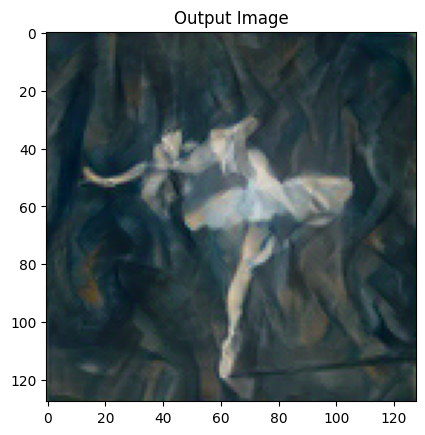

In [51]:
from style_transfer import run_style_transfer

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [52]:
mask = detections.mask[0]
mask = mask.astype(bool)

shape: torch.Size([1, 3, 128, 128])


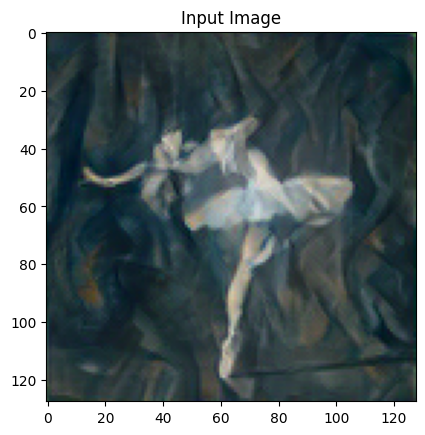

In [53]:
output_img = output.clone()
print(f"shape: {output_img.shape}")

plt.show()
imshow(output_img, title='Input Image')

In [62]:
import torch
import numpy as np
import cv2

content_img_np = content_img.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
styled_img_np = output_img.squeeze().detach().cpu().numpy().transpose(1, 2, 0)

content_img_np = (content_img_np - content_img_np.min()) / (content_img_np.max() - content_img_np.min()) * 255
styled_img_np = (styled_img_np - styled_img_np.min()) / (styled_img_np.max() - styled_img_np.min()) * 255

content_img_np = content_img_np.astype(np.uint8)
styled_img_np = styled_img_np.astype(np.uint8)

content_img_resized = cv2.resize(content_img_np, (mask.shape[1], mask.shape[0]), interpolation=cv2.INTER_AREA)
styled_img_resized = cv2.resize(styled_img_np, (mask.shape[1], mask.shape[0]), interpolation=cv2.INTER_AREA)

print(f"Resized content img shape: {content_img_resized.shape}")
print(f"Resized styled img shape: {styled_img_resized.shape}")

if mask.size == 0:
    print("Error: Mask is empty")

if mask.dtype != np.bool_:
    mask = mask.astype(np.bool_)

Resized content img shape: (444, 444, 3)
Resized styled img shape: (444, 444, 3)


In [63]:
import numpy as np

combined_image = np.zeros_like(styled_img_resized)

for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if mask[i, j]:
            combined_image[i, j] = styled_img_resized[i, j]
        else:
            combined_image[i, j] = content_img_resized[i, j]

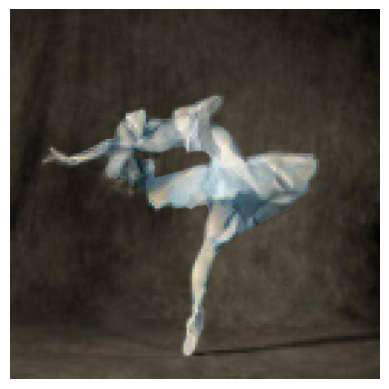

In [64]:
plt.imshow(combined_image)
plt.axis('off')  # To turn off the axis
plt.show()

In [61]:
import cv2

# Convert from RGB to BGR
combined_image_bgr = cv2.cvtColor(combined_image, cv2.COLOR_RGB2BGR)

cv2.imwrite(f'{parent_directory}/data/output_image.jpg', combined_image_bgr)

True